In [34]:
import glob, re

import pandas as pd
import numpy as np

import plotly.express as px

In [35]:
simulations_path = "/home/shoerl/sinfonica/melun/outputs"

### Explore and load all instances

In [36]:
instance_regex = r"fs([0-9]+)_vs([.0-9]+)_vt([0-9]+)_(am|drt)"
df_analysis = []

for instance_path in glob.glob("{}/*".format(simulations_path)):
    instance_name = instance_path.replace("{}/".format(simulations_path), "")
    match = re.match(instance_regex, instance_name)

    if match:
        instance = {
            "fleet_size": int(match.group(1)),
            "vulnerable_share": float(match.group(2)),
            "vulnerable_interaction_time": float(match.group(3)),
            "dispatcher": match.group(4)
        }

        try:
            df_persons = pd.read_csv("{}/output_persons.csv.gz".format(instance_path), sep = ";")
            df_rejections = pd.read_csv("{}/ITERS/it.0/0.drt_rejections_drt.csv".format(instance_path), sep = ";")
            df_legs = pd.read_csv("{}/ITERS/it.0/0.drt_legs_drt.csv".format(instance_path), sep = ";")
        except FileNotFoundError:
            print("Skip", instance_name)
            continue

        df_analysis.append(instance)

        df_persons = df_persons.rename(columns = { "person": "person_id" })
        df_persons["is_vulnerable"] = df_persons["drtInteractionTime"] > 60
        df_persons = df_persons[["person_id", "is_vulnerable"]]

        df_rejections = df_rejections.rename(columns = { "personIds": "person_id" })[["person_id"]]
        df_rejections = pd.merge(df_rejections, df_persons, on = "person_id")
        df_rejections = df_rejections[["person_id", "is_vulnerable"]]

        df_legs = df_legs.rename(columns = { "personId": "person_id", "waitTime": "wait_time" })
        df_legs["detour_factor"] = df_legs["travelDistance_m"] / df_legs["directTravelDistance_m"]
        df_legs = df_legs[["person_id", "wait_time", "detour_factor"]]
        df_legs = pd.merge(df_legs, df_persons, on = "person_id")

        total_legs = len(df_legs)
        total_rejections = len(df_rejections)
        total_requests = total_legs + total_rejections
        
        vulnerable_legs = df_legs["is_vulnerable"].sum()
        vulnerable_rejections = df_rejections["is_vulnerable"].sum()
        vulnerable_requests = vulnerable_legs + vulnerable_rejections

        non_vulernable_legs = total_legs - vulnerable_legs
        non_vulernable_rejections = total_rejections - vulnerable_rejections
        non_vulnerable_requests = non_vulernable_legs + non_vulernable_rejections
        
        instance["rejection_rate"] = total_rejections / total_requests
        instance["vulnerable_rejection_rate"] = vulnerable_rejections / vulnerable_requests if vulnerable_requests > 0 else np.nan
        instance["non_vulnerable_rejection_rate"] = non_vulernable_rejections / non_vulnerable_requests if non_vulnerable_requests > 0 else np.nan

        instance["wait_time"] = df_legs["wait_time"].mean()
        instance["vulnerable_wait_time"] = df_legs[df_legs["is_vulnerable"]]["wait_time"].mean()
        instance["non_vulnerable_wait_time"] = df_legs[~df_legs["is_vulnerable"]]["wait_time"].mean()
        
        instance["detour_factor"] = df_legs["detour_factor"].mean()
        instance["vulnerable_detour_factor"] = df_legs[df_legs["is_vulnerable"]]["detour_factor"].mean()
        instance["non_vulnerable_detour_factor"] = df_legs[~df_legs["is_vulnerable"]]["detour_factor"].mean()

df_analysis = pd.DataFrame.from_records(df_analysis)
df_analysis.head()

Skip fs600_vs0.5_vt240_drt


,fleet_size,vulnerable_share,vulnerable_interaction_time,dispatcher,rejection_rate,vulnerable_rejection_rate,non_vulnerable_rejection_rate,wait_time,vulnerable_wait_time,non_vulnerable_wait_time,detour_factor,vulnerable_detour_factor,non_vulnerable_detour_factor
0,150,0.5,120.0,drt,0.084601,0.117746,0.051294,259.249044,282.407751,237.608263,1.068962,1.052336,1.084498
1,100,0.3,240.0,am,0.351315,0.905008,0.109879,247.227721,337.941423,243.006425,1.010233,1.000516,1.010686
2,25,0.5,120.0,am,0.796283,0.889477,0.702637,348.585900,351.891068,347.351505,1.015840,1.009188,1.018324
3,400,0.5,240.0,drt,0.024258,0.044305,0.004113,225.919109,298.182666,156.236395,1.052715,1.019793,1.084462
4,25,0.5,240.0,am,0.802921,0.982663,0.622308,337.403552,377.416667,335.557976,1.016880,1.008565,1.017264


## Exploration plotting

### Fleet sizing

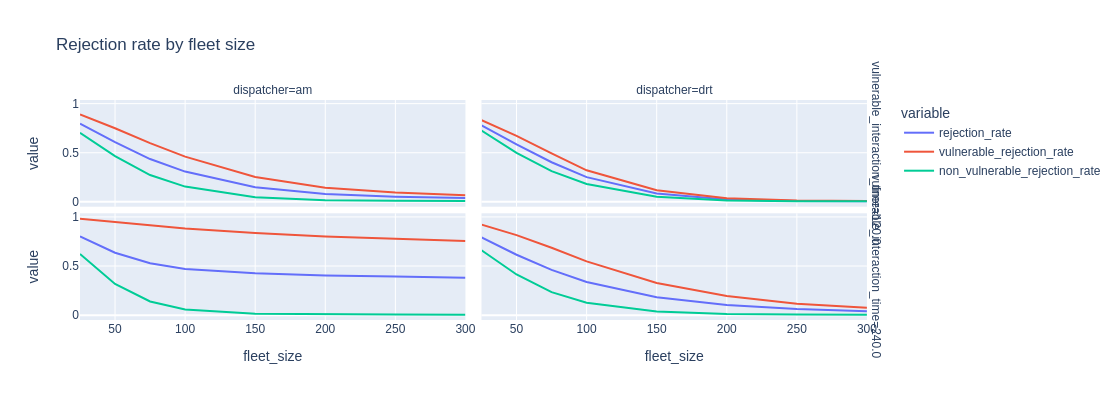

In [50]:
df_plot = df_analysis[
    (df_analysis["vulnerable_share"] == 0.5) & (df_analysis["fleet_size"] <= 300)
].melt(
    ["fleet_size", "vulnerable_interaction_time", "dispatcher"], 
    ["rejection_rate", "vulnerable_rejection_rate", "non_vulnerable_rejection_rate"]
).sort_values(by = ["fleet_size", "vulnerable_interaction_time"])

px.line(df_plot, height = 400, width = 800, title = "Rejection rate by fleet size",
        x = "fleet_size", y = "value", color = "variable", 
        facet_col = "dispatcher", facet_row = "vulnerable_interaction_time")

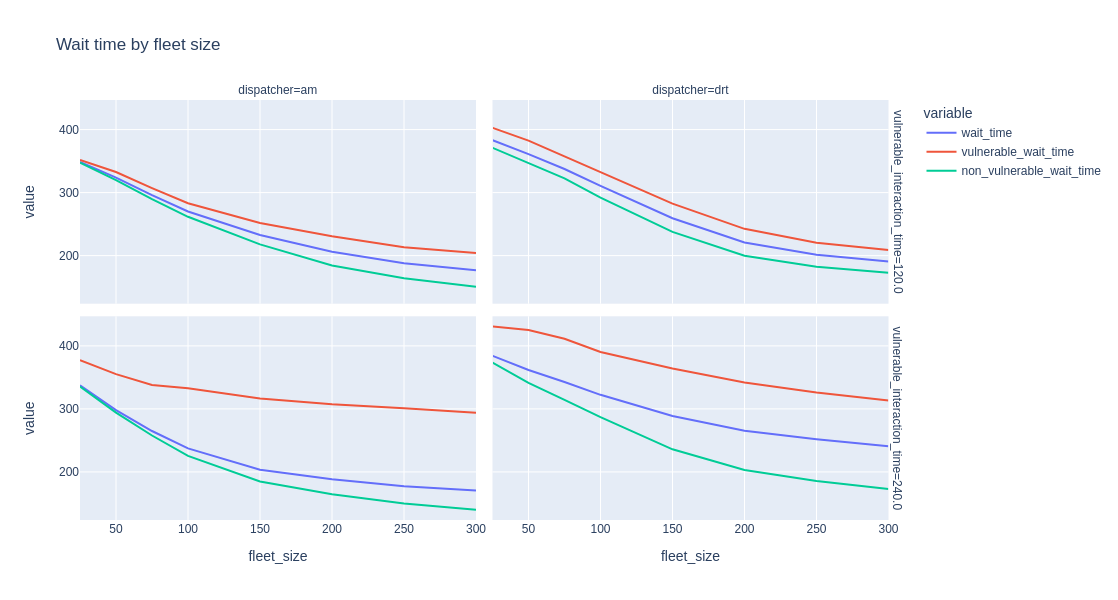

In [38]:
df_plot = df_analysis[
    (df_analysis["vulnerable_share"] == 0.5) & (df_analysis["fleet_size"] <= 300)
].melt(
    ["fleet_size", "vulnerable_interaction_time", "dispatcher"], 
    ["wait_time", "vulnerable_wait_time", "non_vulnerable_wait_time"]
).sort_values(by = ["fleet_size", "vulnerable_interaction_time"])

px.line(df_plot, height = 600, title = "Wait time by fleet size",
        x = "fleet_size", y = "value", color = "variable", 
        facet_col = "dispatcher", facet_row = "vulnerable_interaction_time")

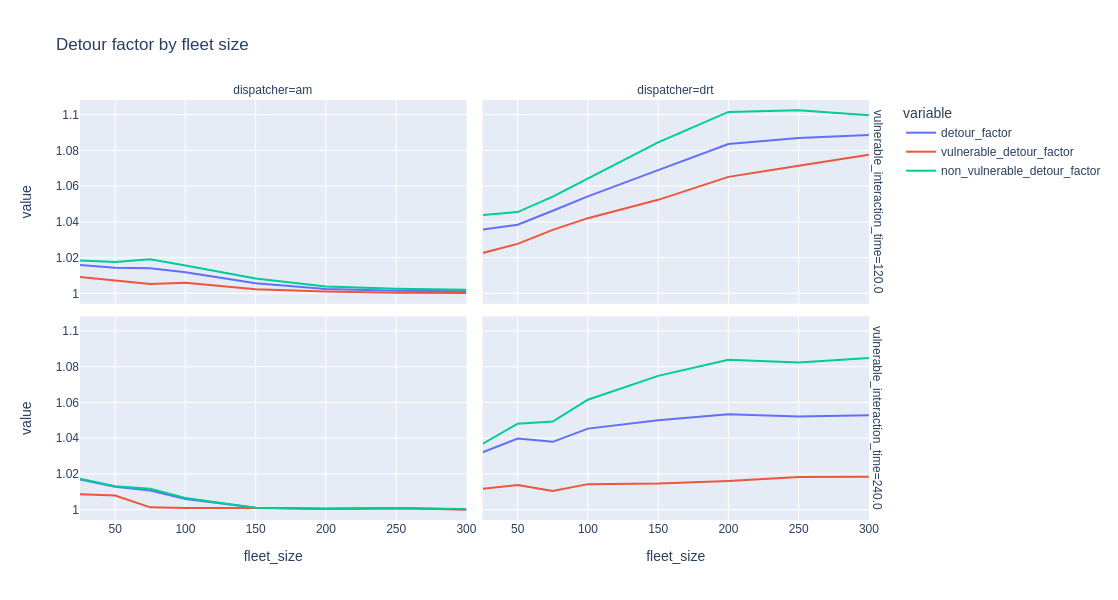

In [39]:
df_plot = df_analysis[
    (df_analysis["vulnerable_share"] == 0.5) & (df_analysis["fleet_size"] <= 300)
].melt(
    ["fleet_size", "vulnerable_interaction_time", "dispatcher"], 
    ["detour_factor", "vulnerable_detour_factor", "non_vulnerable_detour_factor"]
).sort_values(by = ["fleet_size", "vulnerable_interaction_time"])

px.line(df_plot, height = 600, title = "Detour factor by fleet size",
        x = "fleet_size", y = "value", color = "variable", 
        facet_col = "dispatcher", facet_row = "vulnerable_interaction_time")

### Share analysis

In [40]:
analysis_fleet_size = 100

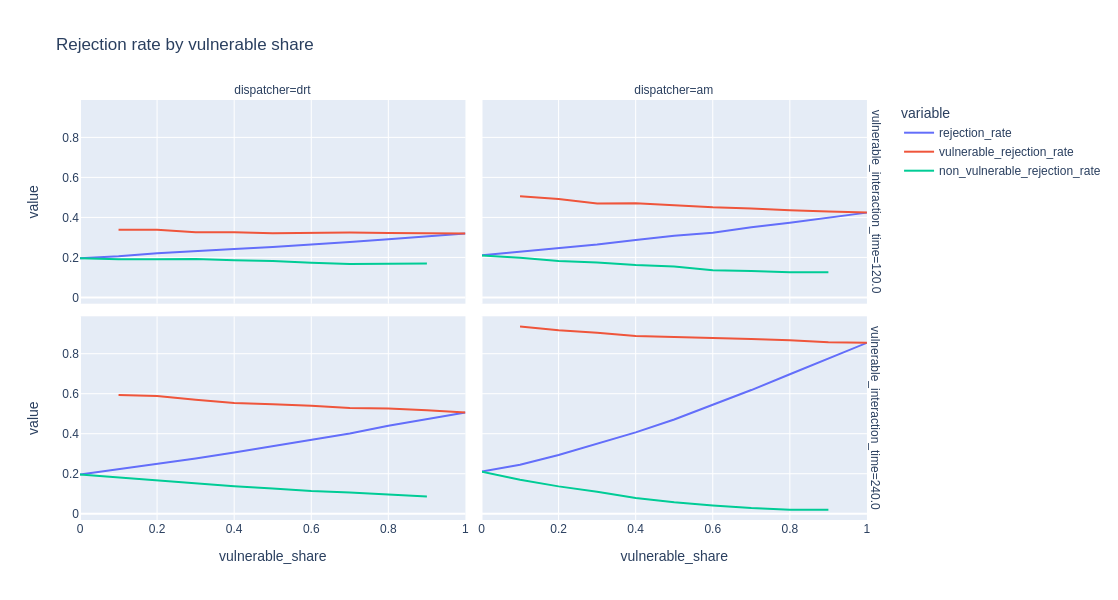

In [41]:
df_plot = df_analysis[
    df_analysis["vulnerable_interaction_time"].isin([120, 240]) & (df_analysis["fleet_size"] == analysis_fleet_size)
].melt(
    ["vulnerable_share", "vulnerable_interaction_time", "dispatcher"], 
    ["rejection_rate", "vulnerable_rejection_rate", "non_vulnerable_rejection_rate"]
).sort_values(by = ["vulnerable_share", "vulnerable_interaction_time"])

px.line(df_plot, height = 600, title = "Rejection rate by vulnerable share", 
        x = "vulnerable_share", y = "value", color = "variable", 
        facet_col = "dispatcher", facet_row = "vulnerable_interaction_time")

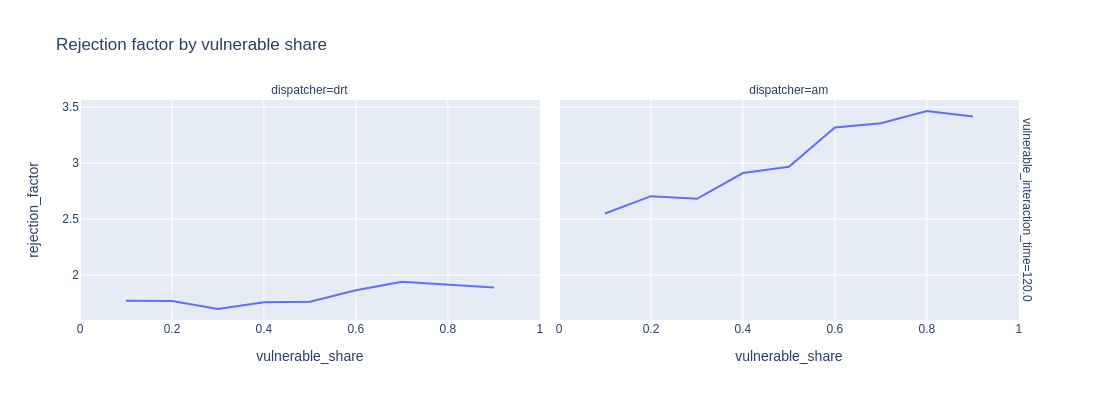

In [42]:
df_plot = df_analysis[
    df_analysis["vulnerable_interaction_time"].isin([120,]) & (df_analysis["fleet_size"] == analysis_fleet_size)
].copy().sort_values(by = [
    "vulnerable_share", "vulnerable_interaction_time"])

df_plot["rejection_factor"] = df_plot["vulnerable_rejection_rate"] / df_plot["non_vulnerable_rejection_rate"]

px.line(df_plot, height = 400, title = "Rejection factor by vulnerable share",
        x = "vulnerable_share", y = "rejection_factor", # color = "variable", 
        facet_col = "dispatcher", facet_row = "vulnerable_interaction_time")

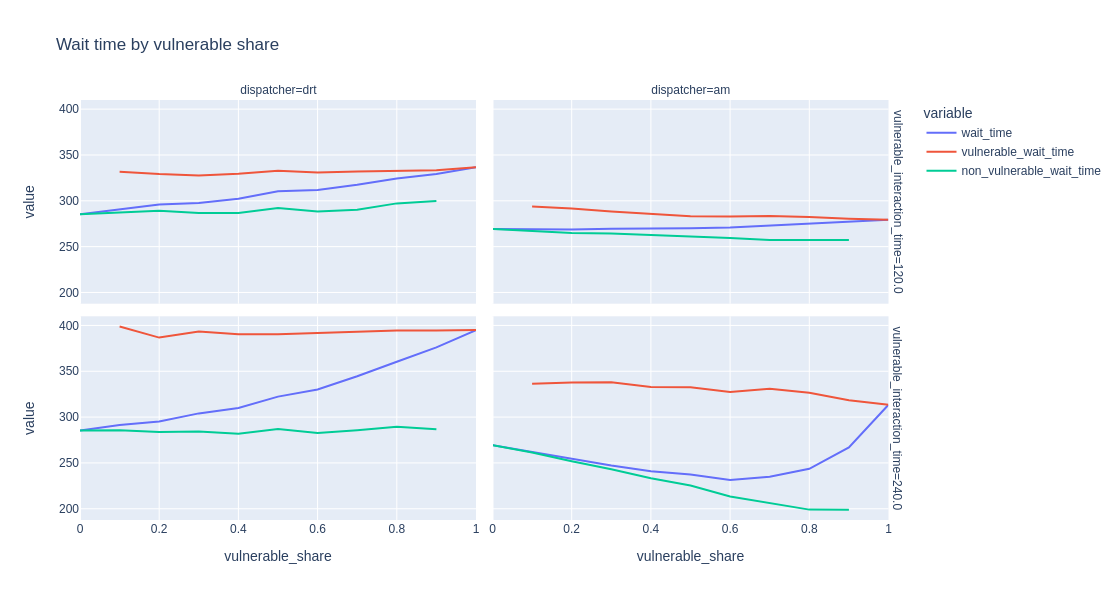

In [43]:
df_plot = df_analysis[
    df_analysis["vulnerable_interaction_time"].isin([120, 240]) & (df_analysis["fleet_size"] == analysis_fleet_size)
].melt(
    ["vulnerable_share", "vulnerable_interaction_time", "dispatcher"], 
    ["wait_time", "vulnerable_wait_time", "non_vulnerable_wait_time"]
).sort_values(by = ["vulnerable_share", "vulnerable_interaction_time"])

px.line(df_plot, height = 600, title = "Wait time by vulnerable share",
        x = "vulnerable_share", y = "value", color = "variable", 
        facet_col = "dispatcher", facet_row = "vulnerable_interaction_time")

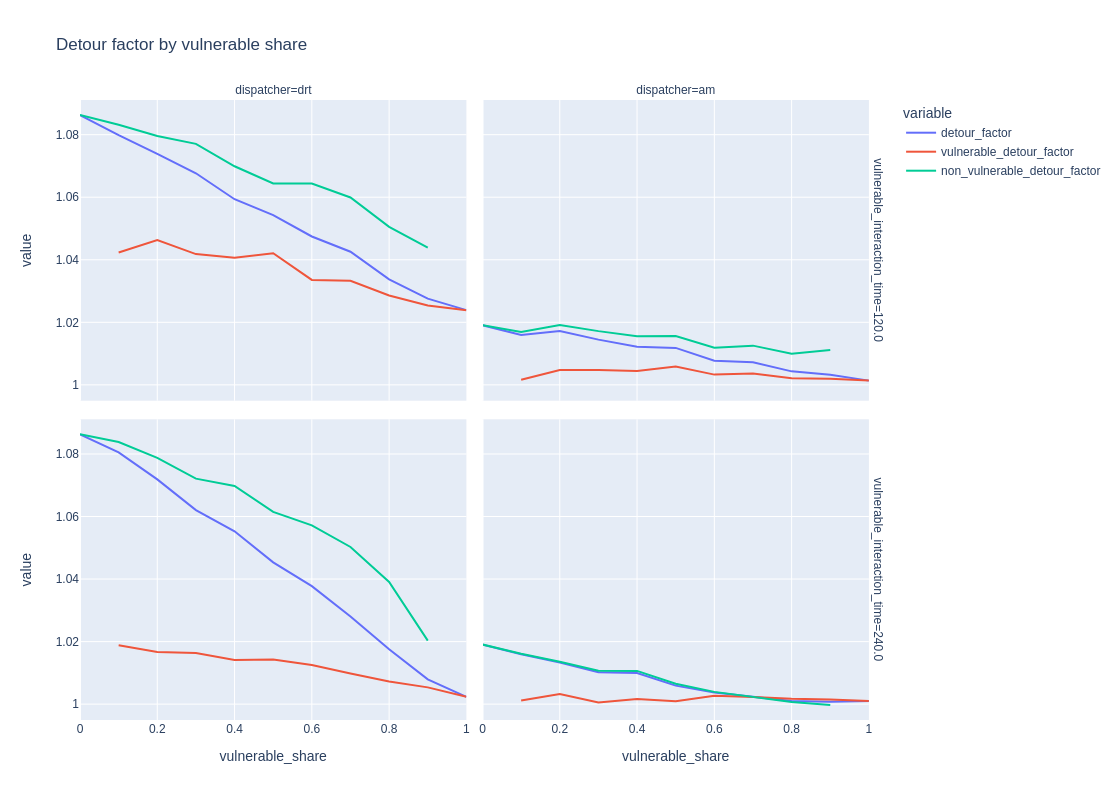

In [44]:
df_plot = df_analysis[
    df_analysis["vulnerable_interaction_time"].isin([120, 240]) & (df_analysis["fleet_size"] == analysis_fleet_size)
].melt(
    ["vulnerable_share", "vulnerable_interaction_time", "dispatcher"], 
    ["detour_factor", "vulnerable_detour_factor", "non_vulnerable_detour_factor"]
).sort_values(by = ["vulnerable_share", "vulnerable_interaction_time"])

px.line(df_plot, height = 800, title = "Detour factor by vulnerable share",
        x = "vulnerable_share", y = "value", color = "variable", 
        facet_col = "dispatcher", facet_row = "vulnerable_interaction_time")